In [1]:
import utilities
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib widget
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
file = '600mV.raw' #File name
T_size = 3000 #Length of 4D-STEM dataset in frames
cores = int(20) #Number of cores to use in the processing

utilities.access_data(file, T_size)

In [3]:
T = int(100) #Pick example diffraction pattern for processing
summing = 1 #How many frames to sum for viewing
intensity_normalization = 100 #This controls diffraction pattern contrast limits

pattern = utilities.get_diff_pattern(T, summing)

In [5]:
#Click on the centra spot, then on the (100) vector, then on the (010) vector. 
#Central spot is at pixel 50, 63
#100 lattice vector at 76, 90
#010 lattice vector at 87, 55

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.imshow(pattern, vmin = np.min(pattern), vmax = np.max(pattern) / intensity_normalization, cmap = 'gray')
cid = fig.canvas.mpl_connect('button_press_event', utilities.onclick)

In [6]:
fig.canvas.mpl_disconnect(cid)
plt.close(1)

In [7]:
import MP_spot_pos_refine_bragg

#Refine the position of the Bragg spots, using user clicks as initial guesses
zero_zero_refined = MP_spot_pos_refine_bragg.spot_pos_refine(1, T, *utilities.coords[0]) 
one_zero_refined = MP_spot_pos_refine_bragg.spot_pos_refine(1, T, *utilities.coords[1])     
zero_one_refined = MP_spot_pos_refine_bragg.spot_pos_refine(1, T, *utilities.coords[2])  

zero_zero_refined = np.array(zero_zero_refined[1:3])
one_zero_refined = np.array(one_zero_refined[1:3])
zero_one_refined = np.array(zero_one_refined[1:3])

np.save('zero_zero_refined.npy', zero_zero_refined)
np.save('one_zero_refined.npy', one_zero_refined)
np.save('zero_one_refined.npy', zero_one_refined)

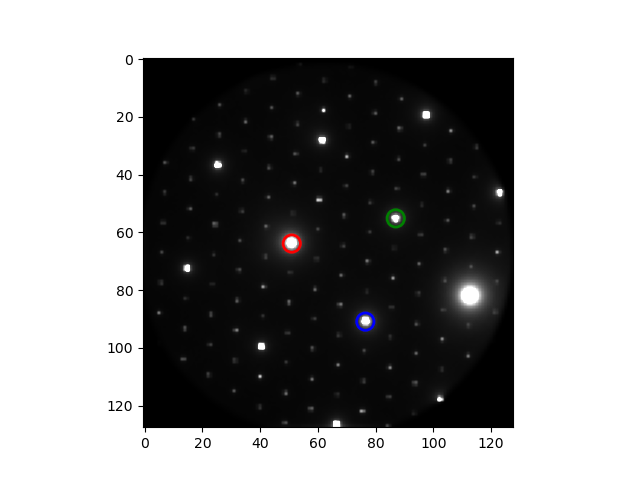

In [8]:
#Define one bragg vector (a)
bragg_vector_1 = one_zero_refined - zero_zero_refined

#Define the second bragg vector (b)
bragg_vector_2 = zero_one_refined - zero_zero_refined

#Plot the diffraction pattern with the Refined spot positions overlaid
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.imshow(pattern, vmax = np.max(pattern) / intensity_normalization, cmap = 'gray')

circ = Circle((zero_zero_refined), radius = 3, color='r', fill = False, linewidth = 2)
ax.add_patch(circ)
    
circ = Circle((zero_zero_refined + bragg_vector_1), radius = 3, color='b', fill = False, linewidth = 2)
ax.add_patch(circ)
    
circ = Circle((zero_zero_refined + bragg_vector_2), radius = 3, color='g', fill = False, linewidth = 2)
ax.add_patch(circ)


In [9]:
plt.close(1)

In [10]:
#Generate guesses for each Bragg spot for every diffraction frame
bragg_spot_guesses = np.zeros((T_size * 7 * 7 , 4))
                            
for T in range (0, T_size):
    for Qi, Qj in ( [-1, 0], [-1,1], [0, -1], [0, 0], [0 ,1], [1, -1], [1, 0] ):
        
        guess = bragg_vector_1*Qi + bragg_vector_2*Qj + zero_zero_refined                    
        counter = T * (7 * 7) + (Qi + 3) * 7 + (Qj + 3)
        bragg_spot_guesses[counter, :] = 1, T, guess[0], guess[1]

#Use multiprocessing to fit the Bragg spots for every diffraction frame        
if __name__ ==  '__main__': 

    p=Pool(cores)  
    result = p.starmap(MP_spot_pos_refine_bragg.spot_pos_refine, bragg_spot_guesses)
    
p.close()
p.join()

result = np.array(result)

#Re-organize spots into bragg_spots array
#First index is the frame #, second and third indexes identify the Bragg reflection, e.g. (hk0), fourth index contains all of the fitted data
#Fourth index information: successful fit? 1 or 0, x_refined, y_refined, total_intensity, distance from guess, peak sharpness, max_intensity, average background value, standard deviation of background
bragg_spots = np.zeros((T_size, 7,7,9)) 

for T in range (0, T_size):
    for Qi in range (-3,4):
        for Qj in range (-3, 4): 
            
            counter = T * (7 * 7) + (Qi + 3) * 7 + (Qj + 3)
            bragg_spots[T, Qi, Qj, :] = result[counter, :]

np.save('bragg_spots.npy', bragg_spots)

In [11]:
#These parameters are used to ensure a given Bragg peak was successfully refined before we use that peak in the starin analysis
distance_tolerance = 1.5 #Pixel offset between initial guess and refined position
SNR_tolerance = 6 #Ratio of the maximum intensity in the bragg peak, over the standard deviation of the background region

#Generate input array for lattice fitting
analysis_input = np.zeros((T_size, 3))
analysis_input[:,0] = np.arange(0, T_size, 1)
analysis_input[:,1] = distance_tolerance
analysis_input[:,2] = SNR_tolerance

#Use multiprocessing to analyze the strain for each diffraction pattern 
import MP_lattice_fitting
if __name__ ==  '__main__': 

    p=Pool(cores)  
    result = p.starmap(MP_lattice_fitting.analysis, analysis_input)
    
p.close()
p.join()  

bragg_analysis = np.array(result)  



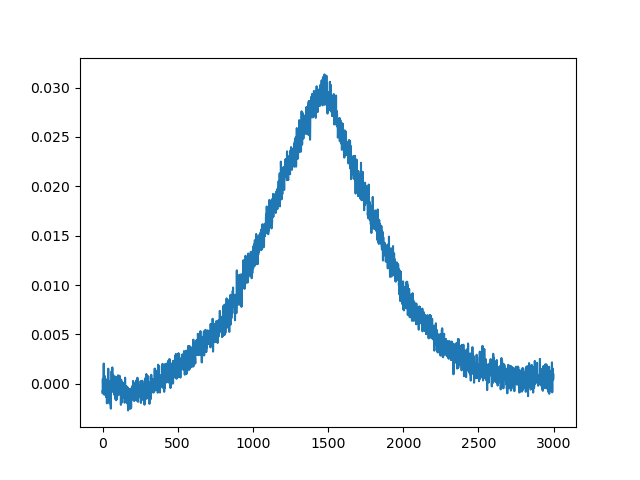

In [12]:
strain = (bragg_analysis[:,1] + bragg_analysis[:,2] ) / 2   #average together the two orthogonal in-plane reciprocal lattice vectors
strain = 1 / strain #take the inverse to go to real-space
strain = 100 * (strain - np.mean(strain[0:10])) / np.mean(strain[0:10]) #Calculate the percent change

plt.plot(strain)

In [14]:
plt.close()